In [184]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random


def make_graph(G):

    # Convertendo o grafo para direcionado caso não seja
    if not nx.is_directed(G):
        print('O grafo está sendo convertido para direcionado..')
        G = G.to_directed()    

    # Renomeando os nós
    n_unique_nodes = len(set(G.nodes()))
    node2int = dict(zip(set(G.nodes()), range(n_unique_nodes)))
    int2node = {v:k for k,v in node2int.items()}

    
    G = nx.relabel_nodes(G, node2int)

    # Removendo nós isolados
    nodes = G.nodes()
    for node in nodes:
        if len(G.edges(node))==0:
            G.remove_node(node)
    return G, int2node       

In [185]:
def plot_graph(G, final_probs, int2node, bool_final_probs=False):
    
    # Renomeando os nós
    labels = int2node

    try:
        clubs = np.array(list(map(lambda x: G.nodes[x]['club'], G.nodes())))
        labels = dict(zip(G.nodes(), clubs)) 
    except:
        pass   

    if not bool_final_probs:
        nx.draw(G, with_labels=True, alpha=0.8, arrows=False, labels=labels)
    else:
        nx.draw(G, with_labels=True, alpha=0.8, arrows=False, node_color = final_probs, \
                                                                                        cmap=plt.get_cmap('viridis'), labels=labels)

        # Adicionando a barra de cores com os valores de ranking
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('viridis'), norm=plt.Normalize(vmin = min(final_probs), vmax=max(final_probs)))
        sm._A = []
        plt.colorbar(sm)  
    return plt

In [186]:
def make_pagerank_matrix(G, d):
    n_nodes = len(G.nodes())

    # Construindo matriz de adjacência
    adj_matrix = np.zeros(shape=(n_nodes, n_nodes))

    for edge in G.edges():
        adj_matrix[edge[0], edge[1]] = 1

    # Construindo a matriz P de probabilidade de transição entre os nós
    tran_matrix = adj_matrix / np.sum(adj_matrix, axis=1).reshape(-1,1)

    # Construindo a matriz de navegação aleatória, onde todos os nós tem a mesma probabilidade de serem visitados
    random_surf = np.ones(shape = (n_nodes, n_nodes)) / n_nodes    

    # Construindo a matriz de transição para nós absorventes
    absorbing_nodes = np.zeros(shape = (n_nodes,))
    for node in G.nodes():
        if len(G.out_edges(node))==0:
            absorbing_nodes[node] = 1
    
    absorbing_node_matrix = np.outer(absorbing_nodes, np.ones(shape = (n_nodes,))) / n_nodes

    # Matriz estocástica
    stochastic_matrix = tran_matrix + absorbing_node_matrix

    # Matriz de transição modificada P' = d * P + (1-d) * [1]/n
    pagerank_matrix = d * stochastic_matrix + (1-d) * random_surf
    return pagerank_matrix

In [187]:
def random_walk(G, d, n_iter):

    n_nodes = len(G.nodes())

    # Vetor inicial com probabilidades iguais para todos os nós
    initial_state = np.ones(shape=(n_nodes,)) / n_nodes
    pagerank_matrix = make_pagerank_matrix(G, d)

    new_initial_state = initial_state
    NORM = []
    for i in range(n_iter):
        final_state = np.dot(np.transpose(pagerank_matrix), new_initial_state)
        
        prev_initial_state = new_initial_state
        new_initial_state = final_state

        L2 = np.linalg.norm(new_initial_state-prev_initial_state)
        NORM.append(L2)

        if np.allclose(new_initial_state, prev_initial_state):
            print(f'Convergiu em {i+1} iterações.')
            break

    plt.figure(figsize=(5,4))
    plt.plot(range(i+1), NORM)
    plt.xlabel('Iterações')
    plt.ylabel('Norma Euclidiana')
    plt.title('Convergência do PageRank')
    plt.show()
    return final_state

In [188]:
def run(G, d, n_iter):
    # Encontrando o ranqueamento dos nós por meio do PageRank

    G, int2node = make_graph(G)

    final_probs = random_walk(G, d, n_iter)

    # Garantindo que as dimensões estão corretas
    assert len(final_probs) == len(G.nodes())

    # Garantindo que as probabilidades somam 1
    assert np.allclose(np.sum(final_probs), 1)
    
    # Printando o ranking dos nós com os nomes originais 
    print('PageRank:')
    for i in np.argsort(final_probs)[::-1]:
        print(f'{int2node[i]}: {final_probs[i]}')
        
    plt.figure(figsize=(25,8))
    plt.subplot(121)
    plot_graph(G, None, int2node, bool_final_probs=False)
    plt.subplot(122)
    plot_graph(G, final_probs, int2node, bool_final_probs=True)
    plt.show()
    return final_probs

O grafo está sendo convertido para direcionado..
Convergiu em 23 iterações.


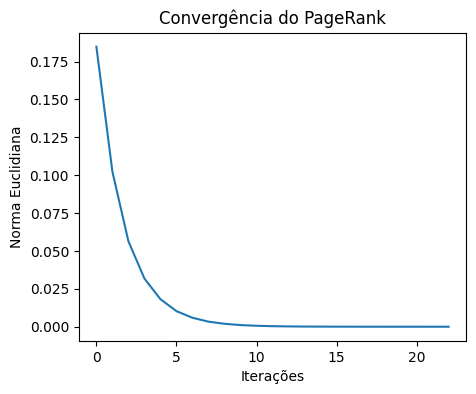

PageRank:
33: 0.0983326247244691
0: 0.09455921473010188
32: 0.07006385169406462
2: 0.05510964853424424
1: 0.05152264785454627
31: 0.03672916791613878
3: 0.035206608959465986
23: 0.03138590153178958
5: 0.029653553788306922
6: 0.029653553788306922
8: 0.029203979444578677
13: 0.028920463870899374
29: 0.02652855510782482
27: 0.025721344844819534
30: 0.024433057089696494
7: 0.024293077926694058
10: 0.022556002956506928
4: 0.022556002956506928
24: 0.021679148799513017
25: 0.021582423916748906
19: 0.019817477926647543
28: 0.019815741078904766
16: 0.017743825861891414
26: 0.015815449009105566
12: 0.015304527916016941
17: 0.015190091982442228
21: 0.015190091982442228
14: 0.015180629154558084
18: 0.015180629154558084
20: 0.015180629154558084
22: 0.015180629154558084
15: 0.015180629154558084
9: 0.014918507474075929
11: 0.01061031056045926


C:\Users\Cole\AppData\Local\Temp\ipykernel_17128\2281756744.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


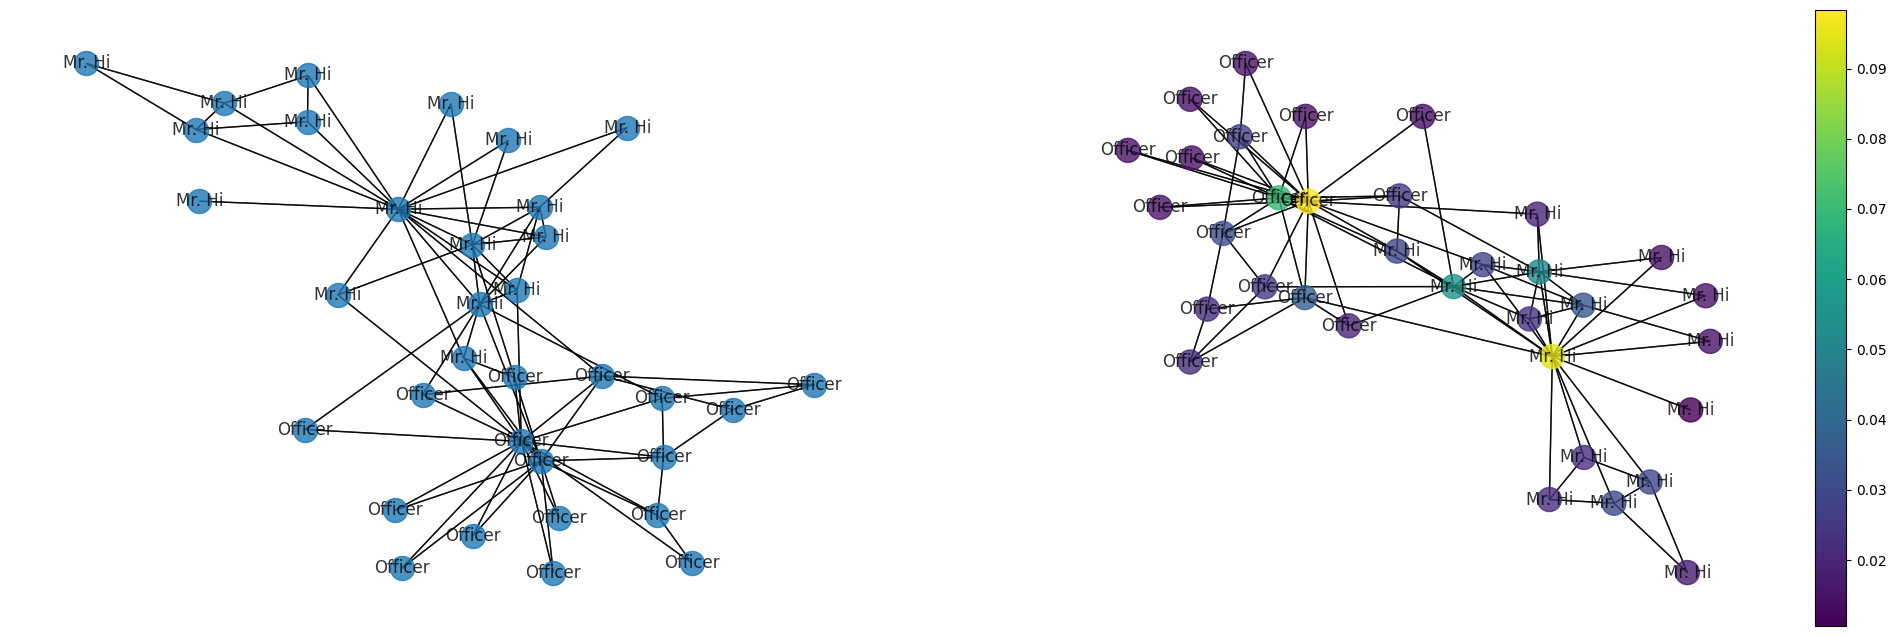

In [199]:
d = 0.8
n_iter = 1000

G = nx.karate_club_graph()
final_probs = run(G, d, n_iter)

In [201]:
# Verificando se bate com o PageRank do NetworkX
ranking = nx.pagerank(G, alpha=0.8, max_iter=1000, tol=1e-06, nstart=None, weight='weight', dangling=None)

# ordenando o dicionário ranking pelos valores
ranking = {k: v for k, v in sorted(ranking.items(), key=lambda item: item[1], reverse=True)}

print(ranking)

{33: 0.09486047671556612, 0: 0.08681447719172829, 32: 0.07407774615757656, 2: 0.06022609788477227, 1: 0.05576990180502326, 31: 0.041092418400124585, 23: 0.04005234377538896, 3: 0.03670727111555245, 5: 0.034116513708762286, 13: 0.03255335020695045, 8: 0.032504029578824645, 6: 0.031875010542794575, 25: 0.02841630372234375, 29: 0.028413382290443677, 27: 0.027151493976771628, 7: 0.026078126588955267, 30: 0.02296983977569958, 10: 0.021394066044403352, 4: 0.021184995124117666, 16: 0.017615950148322918, 24: 0.017273255096315228, 15: 0.016885155427766807, 26: 0.016038313813914594, 28: 0.015095117409551478, 19: 0.013847703406997999, 22: 0.013744564219084298, 14: 0.013723097706681172, 12: 0.012430356457194331, 21: 0.012266674546455183, 20: 0.012142068846138356, 11: 0.010843321085063444, 17: 0.010728169791778151, 18: 0.010603973010401791, 9: 0.01050443442853472}


O grafo está sendo convertido para direcionado..
Convergiu em 32 iterações.


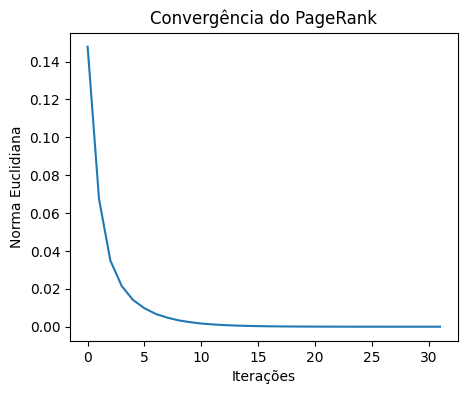

PageRank:
Medici: 0.14296513752634
Guadagni: 0.09762246775467322
Strozzi: 0.08573840106139055
Albizzi: 0.07955949469126551
Tornabuoni: 0.07011770312120269
Castellani: 0.06858391368912006
Ridolfi: 0.06824113770516098
Bischeri: 0.06783478964556114
Peruzzi: 0.06685931815502866
Salviati: 0.06332677049591047
Barbadori: 0.050684543137404996
Pazzi: 0.03866385896410822
Ginori: 0.034549045039561035
Lamberteschi: 0.03285794357648439
Acciaiuoli: 0.03239547543678639


C:\Users\Cole\AppData\Local\Temp\ipykernel_17128\2281756744.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


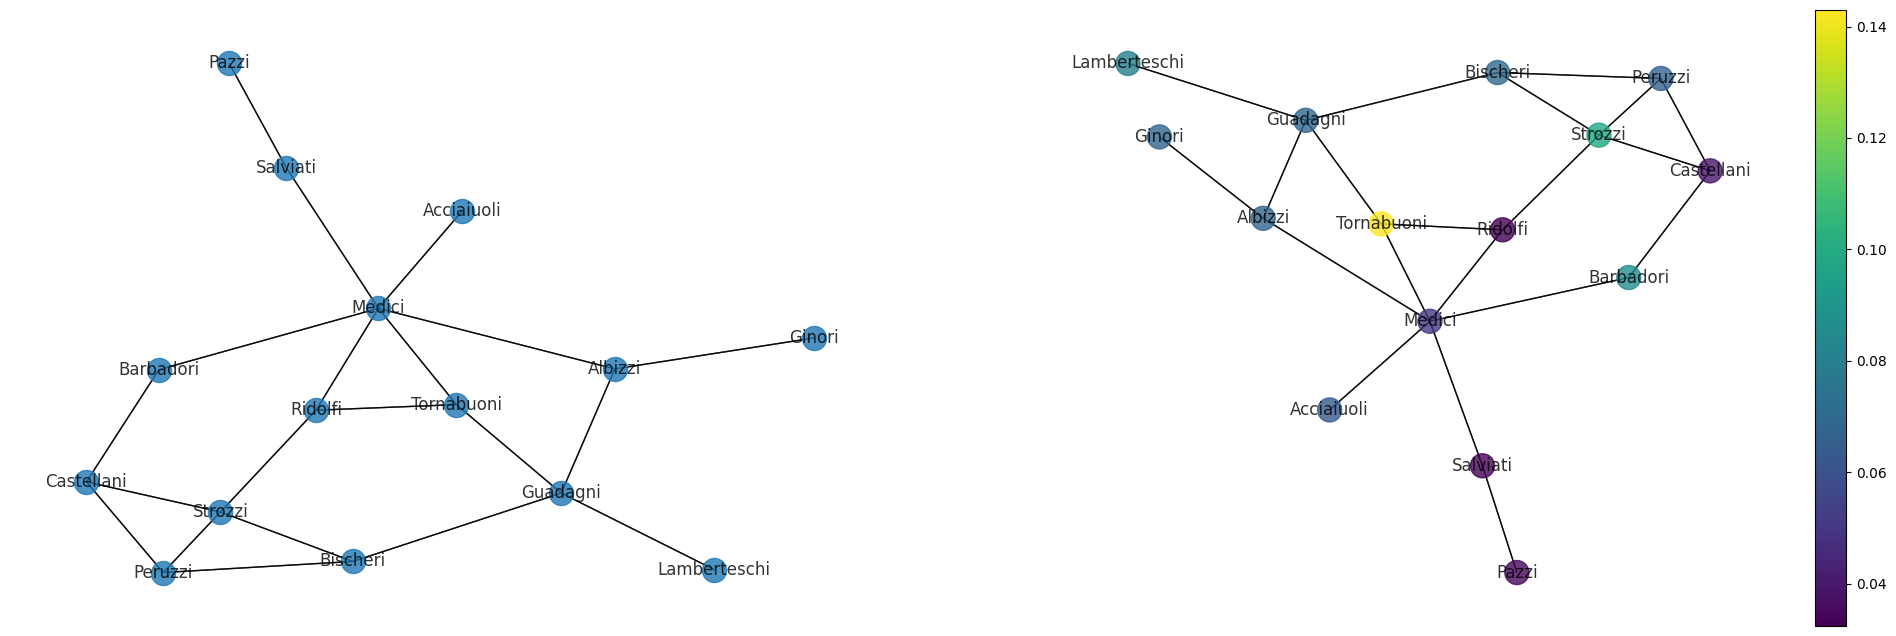

In [202]:
G2 = nx.florentine_families_graph()
final_probs = run(G2, d, n_iter)

In [204]:
# Verificando se bate com o PageRank do NetworkX
ranking = nx.pagerank(G1, alpha=0.8, max_iter=1000, tol=1e-06, nstart=None, weight='weight', dangling=None)

# ordenando o dicionário ranking pelos valores
ranking = {k: v for k, v in sorted(ranking.items(), key=lambda item: item[1], reverse=True)}

print(ranking)

{'Medici': 0.1429665982859834, 'Guadagni': 0.09762337764397065, 'Strozzi': 0.0857384663543674, 'Albizzi': 0.07955860172303533, 'Tornabuoni': 0.07011722466704556, 'Castellani': 0.0685840435238438, 'Ridolfi': 0.06824102510414301, 'Bischeri': 0.06783448428660845, 'Peruzzi': 0.06685933101651127, 'Salviati': 0.0633260733069229, 'Barbadori': 0.05068421893938917, 'Pazzi': 0.038664271610373, 'Ginori': 0.03454938471709383, 'Lamberteschi': 0.032857687558090175, 'Acciaiuoli': 0.03239521126262207}
